# Shoreline change analysis – Bouches-Du-Rhône

This notebook explores shoreline evolution in the Bouches-Du-Rhône using line datasets from **2008** and a more recent IGN BD TOPO® "limite terre–mer" product (here referenced as **2025** in the data paths).

The goal is to:
- visualise the two shorelines on a map,
- build continuous line objects for each year,
- sample points along the 2008 coastline,
- compute the distance to the recent coastline for each sample point,
- and represent these distances along the coastal profile as a 1D curve.

Each code cell below is preceded by an explanation of **what it does**, **why it is needed**, and, when relevant, a short interpretation of the results and the main limitations.


## 1. Imports and basic setup

In this cell we import the core Python libraries used throughout the analysis:
- `geopandas` to handle vector geospatial data (shapefiles);
- `shapely.ops` functions such as `unary_union`, `nearest_points` and `linemerge` to merge and analyse geometries;
- `matplotlib.pyplot` for plotting maps and graphs;
- `numpy` for numerical operations on arrays.

This cell simply prepares the environment and does not produce any output by itself.


In [1]:
import geopandas as gpd
from shapely.ops import unary_union, nearest_points,  linemerge
import matplotlib.pyplot as plt
import numpy as np

## 2. Loading shoreline datasets

This cell loads three line datasets coming from IGN BD TOPO®:
- `df_2008`: shoreline segments (here from `TRONCON_LAISSE`) for **2008**;
- `df_2015`: shoreline segments for **2015** (not used later, but available if we want an intermediate date);
- `df_2025`: the recent shoreline, stored in the `LIMITE_TERRE_MER` layer, which represents the legal land–sea boundary.

At this stage we simply read the shapefiles from disk into GeoDataFrames. A possible limitation here is that the files may not cover exactly the same spatial extent: for example, the 2008 dataset might describe longer portions of the coast than the 2025 dataset, which will later explain some large distances in the 1D curve.


In [ ]:
df_2008 = gpd.read_file(
    "data/D_HYDROGRAPHIE_2008/TRONCON_LAISSE.SHP")

df_2025 = gpd.read_file(
    "data/HYDROGRAPHIE_2025/LIMITE_TERRE_MER.shp")

## 3. First visual comparison on a map

This cell produces a **map comparison** of the two shorelines:
- the 2008 shoreline (`df_2008`) is drawn in a solid line;
- the recent shoreline (`df_2025`) is drawn in **red dashed** style.

The aim is to obtain an intuitive view of how the shoreline has (or has not) moved between 2008 and the recent dataset. At the scale of the whole Bouches-Du-Rhône, the two lines are extremely close, so differences are not obvious by eye: this is expected, because shoreline change usually occurs over **tens of metres** over several decades, not hundreds of metres at the regional scale.

**Limitations and possible improvements:**
- at this scale, very small shifts are visually invisible; zooming on specific sectors would make local changes easier to see;
        
- because the recent dataset does not necessarily cover exactly the same length of coastline as 2008, some sections appear only in blue (2008) or only in red (2025). This mismatch will also impact the distance analysis and generate outliers.


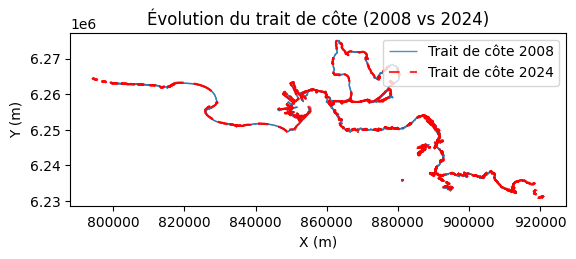

In [ ]:
ax = df_2008["geometry"].plot(
    linewidth=1, label="Trait de côte 2008", alpha=0.8)
df_2025.plot(ax=ax, color="red", linewidth=1.5, linestyle=(0, (5, 5)),
            label="Trait de côte 2025", alpha=0.8)

plt.legend()
plt.title("Évolution du trait de côte (2008 vs 2025)")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.show()

## 4. Building single-line representations for each year

Here we use `unary_union` to merge all the shoreline segments for each year into a single geometry:
- `line_2008` aggregates all geometries from `df_2008` into one (possibly multi-part) line object;
- `line_2024` does the same for the recent `df_2025` dataset.

This step is important because the distance analysis assumes we are working with a **continuous shoreline**, not a collection of small independent segments. In practice, `unary_union` may still return a `MultiLineString` (several disjoint pieces).


In [ ]:
line_2008 = unary_union(df_2008.geometry)
line_2024 = unary_union(df_2025.geometry)

## 5. Sampling points along the 2008 shoreline and computing cumulative distance

In this cell we:
1. Choose a number of sample points `N = 300` along the 2008 shoreline;
2. Use `line_2008.interpolate(i / N, normalized=True)` to create evenly spaced points along the entire 2008 coastline;
3. Compute the **cumulative distance** (`dist_cum`) along the shoreline by measuring the distance between each pair of successive points and summing these distances.

The resulting `dist_cum` array represents a 1D coordinate along the coast: it is the variable we will use on the **x-axis** of the final plot (in kilometres). This turns the 2D shoreline into a 1D profile where each sample point has a unique position along the coastal axis.

**Limitations:**
- If the shoreline geometry contains disconnected parts or internal segments (e.g. river banks, inner lagoons), the interpolation will still sample them, which may lead to distances that are not really representative of open-sea shoreline change.
- The choice of `N = 300` is a compromise: more points would give a smoother curve but increase computation time; fewer points would give a rougher, less detailed profile.


In [ ]:
N = 300


points_2008 = [
    line_2008.interpolate(i / N, normalized=True)
    for i in range(N + 1)
]

dist_cum = [0.0]

for i in range(1, len(points_2008)):
    # distance entre le point i et le point i-1 le long du trait de côte
    d = points_2008[i].distance(points_2008[i - 1])
    dist_cum.append(dist_cum[-1] + d)

dist_cum = np.array(dist_cum)  # conversion en array numpy

## 6. Computing distances from 2008 to the recent shoreline

For each sampled point on the 2008 shoreline, this cell:
- finds the **nearest point** on the recent shoreline (`line_2024`) using `nearest_points` from Shapely;
- computes the Euclidean distance between the two points (in metres, since the data are in a projected CRS);
- stores all distances in the `dist_2008_2024` array.

This gives us a vector of the same length as `points_2008`: for each position along the 2008 coast, we know how far the corresponding recent shoreline segment is located. Small distances (a few metres to a few tens of metres) indicate relatively stable sectors, whereas larger distances may reveal dynamic zones or, in some cases, artefacts.

**Important caveat:** some very large distances do **not** necessarily correspond to real shoreline retreat or advance. They often occur where the 2008 shoreline continues beyond the spatial coverage of the 2025 dataset. These outliers should be treated with care, and it can be justified to filter or mask distances above a certain threshold (e.g. 150–200 m) when interpreting the results.


In [ ]:
dist_2008_2024 = []

for p in points_2008:
    p_2024 = nearest_points(p, line_2024)[1]
    d = p.distance(p_2024)  # en mètres (Lambert 93)
    dist_2008_2024.append(d)

dist_2008_2024 = np.array(dist_2008_2024)

## 7. 1D shoreline-change profile and interpretation

This final cell plots the **1D shoreline-change profile**:
- the x-axis shows the cumulative distance along the 2008 shoreline (converted to kilometres);
- the y-axis shows the distance between the 2008 and recent shorelines (in metres) at each sampled point.

The resulting curve allows us to identify:
- sectors where the two shorelines are very close (small values), suggesting limited horizontal movement over the 2008–2024 period;
- sectors with larger distances, which may correspond either to more active coastal dynamics (erosion/accretion) **or** to mismatches between the two datasets (missing segments, internal features, different mapping conventions).

In practice, it is useful to:
- compute basic statistics (mean, median, maximum) of `dist_2008_2024`;
- inspect and possibly **filter** distances above a threshold (e.g. 150–200 m) that are clearly driven by data coverage issues rather than genuine shoreline movement;
- combine this profile with a map view, highlighting where the largest distances occur along the coast.

**Possible extensions / to go further:**
- Restrict the analysis to the section of coast that is covered in both datasets (intersection of 2008 and 2025 shoreline extents).
- Repeat the analysis using an intermediate date (e.g. 2015) to obtain a multi-period view of shoreline evolution.
- Classify the coastline into sectors (e.g. river mouths, barrier beaches, urbanised zones) and compare the statistics of shoreline change between these different geomorphological units.


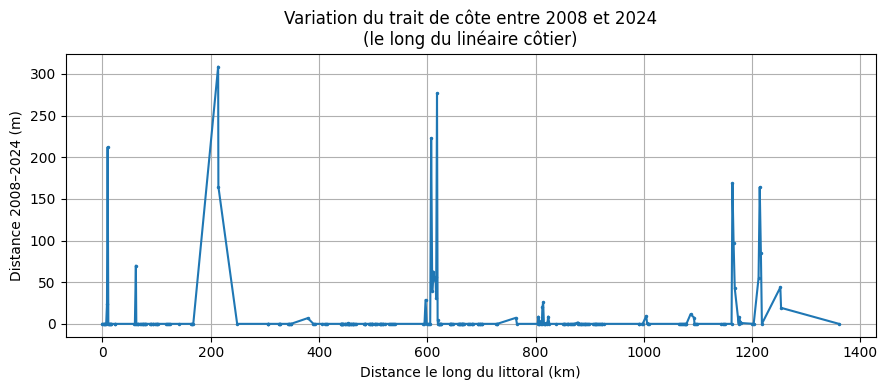

In [ ]:
plt.figure(figsize=(9, 4))

plt.plot(dist_cum / 1000, dist_2008_2024,
         marker=".", markersize=3, linestyle="-")

plt.xlabel("Distance le long du littoral (km)")
plt.ylabel("Distance 2008–2024 (m)")
plt.title(
    "Variation du trait de côte entre 2008 et 2024\n(le long du linéaire côtier)")
plt.grid(True)
plt.tight_layout()
plt.show()